# SIMPLE model for simulation growth of wheat

#### taken from:

[1] https://www.researchgate.net/publication/331446151_A_SIMPLE_crop_model

[2] https://www.pnas.org/content/pnas/117/32/19131.full.pdf


In [1]:
import math

class simpleWheat:
    
    def __init__(self):
        
        self.RUE = 1.5  # g/MJ  according to [2] but 1.24 according to [1]
        self.Harvest_idx = 0.38 # from [2]
        self.biomass_cum = 0
        self.f_solar_max = 0.95 # from [1]
        self.termal_time_current = 0
        self.t_opt = 15 # celsius
        self.t_base = 0 # celsius
        self.temp_time_increment =  self.t_opt - self.t_base # increment per day
        self.s_co2 = 0.08 # from [1]
        self.t_sum = 1600 # termal time from sowing to maturity in dayly mean temp, from [2]
        self.I_50_a = 200 # termal time, [2]
        self.I_50_b = 200 # termal time, [2]
        
    
    def Yield(self):
        return self.biomass_cum * self.Harvest_idx
    
    def f_solar(self, TT):
        x = -0.01 * ( TT - self.I_50_a )
        if TT > (self.t_sum - 4* self.I_50_b) :
            x = 0.01 * ( TT - (self.t_sum - self.I_50_b) )
            
        den = 1 + math.exp(x)
        return self.f_solar_max / den
    
    def f_co2(self):
        return ( 1 + 350 * self.s_co2 )
    
    # Formula (3) in [1] 
    # here we assume optimal conditions so:
    # f_heat, f_water, f_temp = 1
    def biomassRate(self, sun_flux, TT):
        # sun_flux is in MJ
        bio_g_per_m2_s = sun_flux * self.f_solar(TT) * self.RUE * self.f_co2()
        return bio_g_per_m2_s
    
        

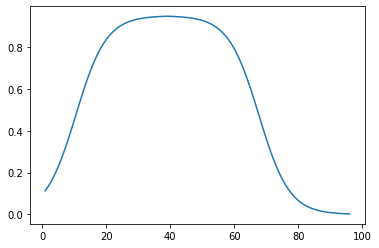

51.80359653880324


In [2]:
from matplotlib import pyplot as plt 
w = simpleWheat()
TT = range(0,2000, int(15 * 20/14) )
d = list(range(1, len(TT) +1))

y = []
for x in TT:
    y.append(w.f_solar(x))

fsolar = y[0:70]
fsolar_cum = 0
for f in fsolar:
    fsolar_cum = fsolar_cum + f

plt.plot(d,y)
plt.show()
print(fsolar_cum)

In [3]:
# bumblgee 
irradiance_b = 50 # MJ/m^2/day
day_to_mature_b = fsolar_cum
RUE_b = 1.5 # g/MJ
harvest_index = 0.38

biomass_b_m2 = irradiance_b * RUE_b * day_to_mature_b * harvest_index # g/m^2
biomass_hec = biomass_b_m2 * 10000  * 1E-6 # tonne/hectar
print(biomass_hec)

14.764025013558923


In [4]:
3.8*10000 / 1000 * harvest_index

14.44

# Notes

The above model makes very little sense because it takes as main ingredient the time-temperature, how long it takes from seed to harvest is in this form. It makes sense for stuff outside since major player is actually temperature, but for indoor is not any more and other factors dominate, for example the f_solar must be a function of growth not temperature.

Untill I find a better way, we need to stick to the following back of envelope calculation:

In [5]:
maximum_harvest_per_ha = 39 # tonne/ha [2] 
# handwavingly, they also modify temp_time_increment because of more hour of light exposure in a day (we cant)
number_harvest_year =  365 / ( w.t_sum / w.temp_time_increment ) 
yearly_yield = maximum_harvest_per_ha * number_harvest_year # tonne / ha

swiss_yield_per_ha = 6.8 # tonne/ha -  https://www.indexmundi.com/facts/switzerland/indicator/AG.YLD.CREL.KG

effective_factor = yearly_yield / swiss_yield_per_ha
print("how many times better than swiss ha per ha", effective_factor)

how many times better than swiss ha per ha 19.62545955882353


In [6]:
average_solar_irradiance_sud_CH_day = 1600 / 365 # kWh/m^2   - https://www.swissolar.ch/en/about-solar/facts-and-figures/infographics/#:~:text=Solar%20radiation%20in%20Switzerland,energy%20consumption%20of%20our%20country.

kwh_to_MJ = 3.6 # MJ/kWh

# this is because I already considered above a reduced number of harvest, otherwise 5 harvests
corrected_irradiance_b = irradiance_b / 20 * 11 # 20 hours bumb vs 11 hours average day (over year)

average_area_to_equal_b_irradiance = corrected_irradiance_b / ( average_solar_irradiance_sud_CH_day * kwh_to_MJ )

print("solar panel area needed for 1 m^2 of wheat", average_area_to_equal_b_irradiance)


solar panel area needed for 1 m^2 of wheat 1.742621527777778


In [7]:
one_hectar = 10000 # m^2
instrumented_area_hectar_equivalent = one_hectar / effective_factor * average_area_to_equal_b_irradiance
print("hectar equivalent [m^2]", instrumented_area_hectar_equivalent)
print("final gain factor", one_hectar / instrumented_area_hectar_equivalent)

hectar equivalent [m^2] 887.9392212725547
final gain factor 11.262032085561495


In [8]:
pod_area = 2 * math.pi * 5
pod_per_hectar_equivalent = instrumented_area_hectar_equivalent / pod_area
print("numper of pods per ha ", pod_per_hectar_equivalent)

numper of pods per ha  28.263983246139063


In [10]:
cost_per_pod = 5000 #chf optimistic (see other notebook for a break down)
cost_per_ha = pod_per_hectar_equivalent * cost_per_pod
print("cost per instrumented ha kCHF", int(cost_per_ha / 1000) )

cost per instrumented ha kCHF 141
